In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv
/kaggle/input/horse-colic/horse.csv
/kaggle/input/horse-colic/datadict.txt
/kaggle/input/horse-survival-dataset/horse.csv


## 导入必要的库

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from colorama import Fore, Style, init

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import mutual_info_classif
from scipy import stats

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## 读取数据

In [53]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
original_df = pd.read_csv('/kaggle/input/horse-survival-dataset/horse.csv')
train_df = train_df.set_index("id")
test_df = test_df.set_index("id")

original_df.index = range(len(original_df))
original_df.index+= max(test_df.index) + 1
original_df.index.name = 'id'
original_df = original_df.reindex(train_df.columns, axis=1)

#是否合并train和original
# train_df = pd.concat([train_df, original_df], axis=0, ignore_index = True)

## datadict

In [54]:
# with open('/kaggle/input/horse-colic/datadict.txt', 'r') as file:
#    for line in file:
#        print(line)

## 常用函数

In [55]:
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + style)

# 字典编码函数  排序映射赋值（有序离散object处理）
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value),index=value))).values
# 多变量分析  将两个变量融合进而分析
def combine_feature(df):
    cols = df.columns
    feature1 = df[cols[0]].astype(str).values.tolist()
    feature2 = df[cols[1]].astype(str).values.tolist()
    return pd.Series([feature1[i] + '&' + feature2[i] for i in range(df.shape[0])])

## EDA

In [56]:
# Train
PrintColor(f"\nTrain set head", color = Fore.BLUE)
display(train_df.head(5).style.format(precision = 3))
PrintColor(f"\nTrain set description", color = Fore.BLUE)
display(train_df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).transpose().
                            drop(columns = ['count'], errors = 'ignore').
                            style.format(formatter = '{:,.2f}').
                            background_gradient(cmap = 'Purples'))
PrintColor(f"\nTrain set Information", color = Fore.BLUE)
display(train_df.info())

feature_columns = train_df.columns[:-1]
target = train_df.columns[-1]

# Test
PrintColor(f"\nTest set head", color = Fore.BLUE)
display(test_df.head(5).style.format(precision = 3))
PrintColor(f"\Test set description", color = Fore.BLUE)
display(test_df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).transpose().
                            drop(columns = ['count'], errors = 'ignore').
                            style.format(formatter = '{:,.2f}').
                            background_gradient(cmap = 'Purples'))
PrintColor(f"\Test set Information", color = Fore.BLUE)
display(test_df.info())
# Original
PrintColor(f"\nOriginal set head", color = Fore.BLUE)
display(original_df.head(5).style.format(precision = 3))
PrintColor(f"\Original set description", color = Fore.BLUE)
display(original_df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).transpose().
                            drop(columns = ['count'], errors = 'ignore').
                            style.format(formatter = '{:,.2f}').
                            background_gradient(cmap = 'Purples'))
PrintColor(f"\Original set Information", color = Fore.BLUE)
display(original_df.info())


Train set head



Train set description



Train set Information
<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null  

None


Test set head


\Test set description


\Test set Information
<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1235 to 2058
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    object 
 1   age                    824 non-null    object 
 2   hospital_number        824 non-null    int64  
 3   rectal_temp            824 non-null    float64
 4   pulse                  824 non-null    float64
 5   respiratory_rate       824 non-null    float64
 6   temp_of_extremities    789 non-null    object 
 7   peripheral_pulse       777 non-null    object 
 8   mucous_membrane        811 non-null    object 
 9   capillary_refill_time  818 non-null    object 
 10  pain                   795 non-null    object 
 11  peristalsis            805 non-null    object 
 12  abdominal_distention   802 non-null    object 
 13  nasogastric_tube       760 non-null    object 
 14  nasogastric_reflux     810 non-null  

None


Original set head


\Original set description


\Original set Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 2059 to 2357
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 n

None

## 1.hospital_number 有重复、出现数值很大的编号、是否应该当成离散量重新编一下码----作为类别变量----独热编码
##   hospital_number 在test中出现但在train中没出现 ---- 需要test和train合并编码
## 2.lesion_1、lesion_2、lesion_3数据比较有问题，需要如何处理
##  2.1lesion_2为非0，outcome为非died
##     可处理df['lesion_2'] = df['lesion_2'].apply(lambda x:1 if x>0 else 0)  （预测died变好？）
##     作为类别变量处理
##  2.2lesion_3只有两个值，lession_3非0，outcome非died
##     同上处理？
##     作为类别变量处理
##  2.3查看到其特征解释貌似可以拆解开分为多个特征
##     见datadict

## other tricks
## 1.马儿的温度影响outcome，偏离37.8越多越容易死
##   df["deviation_from_normal_temp"] = df["rectal_temp"].apply(lambda x: abs(x - 37.8))
## 2.pulse, respiatory_rate, packed_cell_volume是否可以如1

In [57]:
# 数据正确性验证
# 缺失值
# 异常值
# 规律性分析 （单变量分析、多变量分析）
# 离散型变量区分、名义型变量（男女-10）、有序（考虑是否当成连续）

In [58]:
# 缺失数据分析1
PrintColor(f"\nTrain set null values", color = Fore.BLUE)
train_missing = train_df.isnull().sum() * 100 / len(train_df)
train_missing = train_missing[train_missing != 0]
train_missing = pd.DataFrame({'missing percent': train_missing})
train_missing = train_missing.sort_values('missing percent', ascending=False)
display(train_missing)
for col in train_missing.index:
    print(col,train_df[col].unique())#此处缺失值如何去补充
    
PrintColor(f"\nTest set null values", color = Fore.BLUE)
test_missing = test_df.isnull().sum() * 100 / len(test_df)
test_missing = test_missing[test_missing != 0]
test_missing = pd.DataFrame({'missing percent': test_missing})
test_missing = test_missing.sort_values('missing percent', ascending=False)
display(test_missing)
for col in test_missing.index:
    print(col,test_df[col].unique())#此处缺失值如何去补充



Train set null values


missing percent
abdomen                      17.246964
rectal_exam_feces            15.384615
nasogastric_tube              6.477733
peripheral_pulse              4.858300
abdomo_appearance             3.886640
pain                          3.562753
temp_of_extremities           3.157895
abdominal_distention          1.862348
mucous_membrane               1.700405
nasogastric_reflux            1.700405
peristalsis                   1.619433
capillary_refill_time         0.485830

abdomen ['distend_small' 'distend_large' 'normal' 'firm' nan 'other']
rectal_exam_feces ['decreased' 'absent' nan 'normal' 'increased' 'serosanguious']
nasogastric_tube ['slight' 'none' 'significant' nan]
peripheral_pulse ['reduced' 'normal' nan 'absent' 'increased']
abdomo_appearance ['serosanguious' 'cloudy' 'clear' nan]
pain ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight']
temp_of_extremities ['cool' 'cold' 'normal' 'warm' nan]
abdominal_distention ['slight' 'moderate' 'none' 'severe' nan]
mucous_membrane ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]
nasogastric_reflux ['less_1_liter' 'more_1_liter' 'none' nan 'slight']
peristalsis ['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small']
capillary_refill_time ['more_3_sec' 'less_3_sec' nan '3']

Test set null values


missing percent
abdomen                      18.689320
rectal_exam_feces            15.169903
nasogastric_tube              7.766990
peripheral_pulse              5.703883
temp_of_extremities           4.247573
abdomo_appearance             3.762136
pain                          3.519417
abdominal_distention          2.669903
peristalsis                   2.305825
nasogastric_reflux            1.699029
mucous_membrane               1.577670
capillary_refill_time         0.728155

abdomen ['distend_small' 'distend_large' nan 'other' 'firm' 'normal']
rectal_exam_feces ['normal' 'decreased' 'absent' nan 'increased']
nasogastric_tube ['none' 'slight' nan 'significant']
peripheral_pulse ['normal' 'reduced' nan 'absent' 'increased']
temp_of_extremities ['normal' 'cool' nan 'cold' 'warm']
abdomo_appearance ['clear' 'serosanguious' 'cloudy' nan]
pain ['mild_pain' 'depressed' 'severe_pain' 'extreme_pain' nan 'moderate'
 'alert']
abdominal_distention ['slight' 'moderate' 'severe' 'none' nan]
peristalsis ['hypomotile' 'absent' 'hypermotile' nan 'normal']
nasogastric_reflux ['none' 'more_1_liter' 'less_1_liter' nan]
mucous_membrane ['normal_pink' 'bright_pink' 'bright_red' 'pale_cyanotic' 'dark_cyanotic'
 'pale_pink' nan]
capillary_refill_time ['less_3_sec' 'more_3_sec' nan '3']


In [59]:
# 缺失数据分析2
def summary_df(train_df,test_df):
    summary = pd.DataFrame(train_df.dtypes, columns=['dtypes'])
    summary['train_missing#'] = train_df.isna().sum()
    summary['train_missing%'] = (train_df.isna().sum())/len(train_df)
    summary['train_uniques'] = train_df.nunique().values
    summary['train_count'] = train_df.count().values
    # summary['train_skew'] = train_df.skew().values
    summary['test_missing#'] = test_df.isna().sum()
    summary['test_missing%'] = (test_df.isna().sum())/len(test_df)
    summary['test_uniques'] = test_df.nunique().values
    summary['test_count'] = test_df.count().values
    # summary['test_skew'] = train_df.skew().values
    return summary
summary_df(train_df[train_df.columns[:-1]],test_df).style.background_gradient(cmap='Blues')

## 1.缺失值数据均为object类型
## 2.缺失值数据中的nan，有些还有none的存在，应该如何处理nan。  检查了一下数据发现是大写的None和小写的none的问题？
##   好像两者是不同的
## 3.

In [60]:
# 寻找object类型、或者直接规定
dtypes = train_df.dtypes.to_dict()
cat_cols = []
num_cols = []
for column, typ in dtypes.items():
    if typ == "object":
        cat_cols.append(column)
    else:
        num_cols.append(column)

# 独特性验证(类别类、独特类（id等）)
for col in cat_cols:
    print('Train   ',col,train_df[col].unique())
    print('Original   ',col,original_df[col].unique())
    if col=='outcome':
        continue
    print('Test   ',col,test_df[col].unique())

def unique_validation(train_df,test_df,original_df,features):
    for feature in features:
        print('train',feature,train_df[feature].unique())
        print('test',feature,test_df[feature].unique())
        print('original',feature,original_df[feature].unique())

        print('original_unique_to_train',feature,[original_unique_to_train for original_unique_to_train in original_df[feature].unique() if original_unique_to_train not in train_df[feature].unique()])
        print('test_unique_to_train',feature,[test_unique_to_train for test_unique_to_train in test_df[feature].unique() if test_unique_to_train not in train_df[feature].unique()])
        print('train_unique_to_original',feature,[train_unique_to_original for train_unique_to_original in train_df[feature].unique() if train_unique_to_original not in original_df[feature].unique()])
        print('train_unique_to_test',feature,[train_unique_to_test for train_unique_to_test in train_df[feature].unique() if train_unique_to_test not in test_df[feature].unique()])
        print('original_unique_to_test',feature,[original_unique_to_test for original_unique_to_test in original_df[feature].unique() if original_unique_to_test not in test_df[feature].unique()])
        print('test_unique_to_original',feature,[test_unique_to_original for test_unique_to_original in test_df[feature].unique() if test_unique_to_original not in original_df[feature].unique()])

unique_validation(train_df,test_df,original_df,['lesion_1','lesion_2','lesion_3'])#,'hospital_number'

Train    surgery ['yes' 'no']
Original    surgery ['no' 'yes']
Test    surgery ['no' 'yes']
Train    age ['adult' 'young']
Original    age ['adult' 'young']
Test    age ['adult' 'young']
Train    temp_of_extremities ['cool' 'cold' 'normal' 'warm' nan]
Original    temp_of_extremities ['cool' nan 'normal' 'cold' 'warm']
Test    temp_of_extremities ['normal' 'cool' nan 'cold' 'warm']
Train    peripheral_pulse ['reduced' 'normal' nan 'absent' 'increased']
Original    peripheral_pulse ['reduced' nan 'normal' 'absent' 'increased']
Test    peripheral_pulse ['normal' 'reduced' nan 'absent' 'increased']
Train    mucous_membrane ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]
Original    mucous_membrane [nan 'pale_cyanotic' 'pale_pink' 'dark_cyanotic' 'normal_pink'
 'bright_red' 'bright_pink']
Test    mucous_membrane ['normal_pink' 'bright_pink' 'bright_red' 'pale_cyanotic' 'dark_cyanotic'
 'pale_pink' nan]
Train    capillary_refill_time ['more_3_sec' 

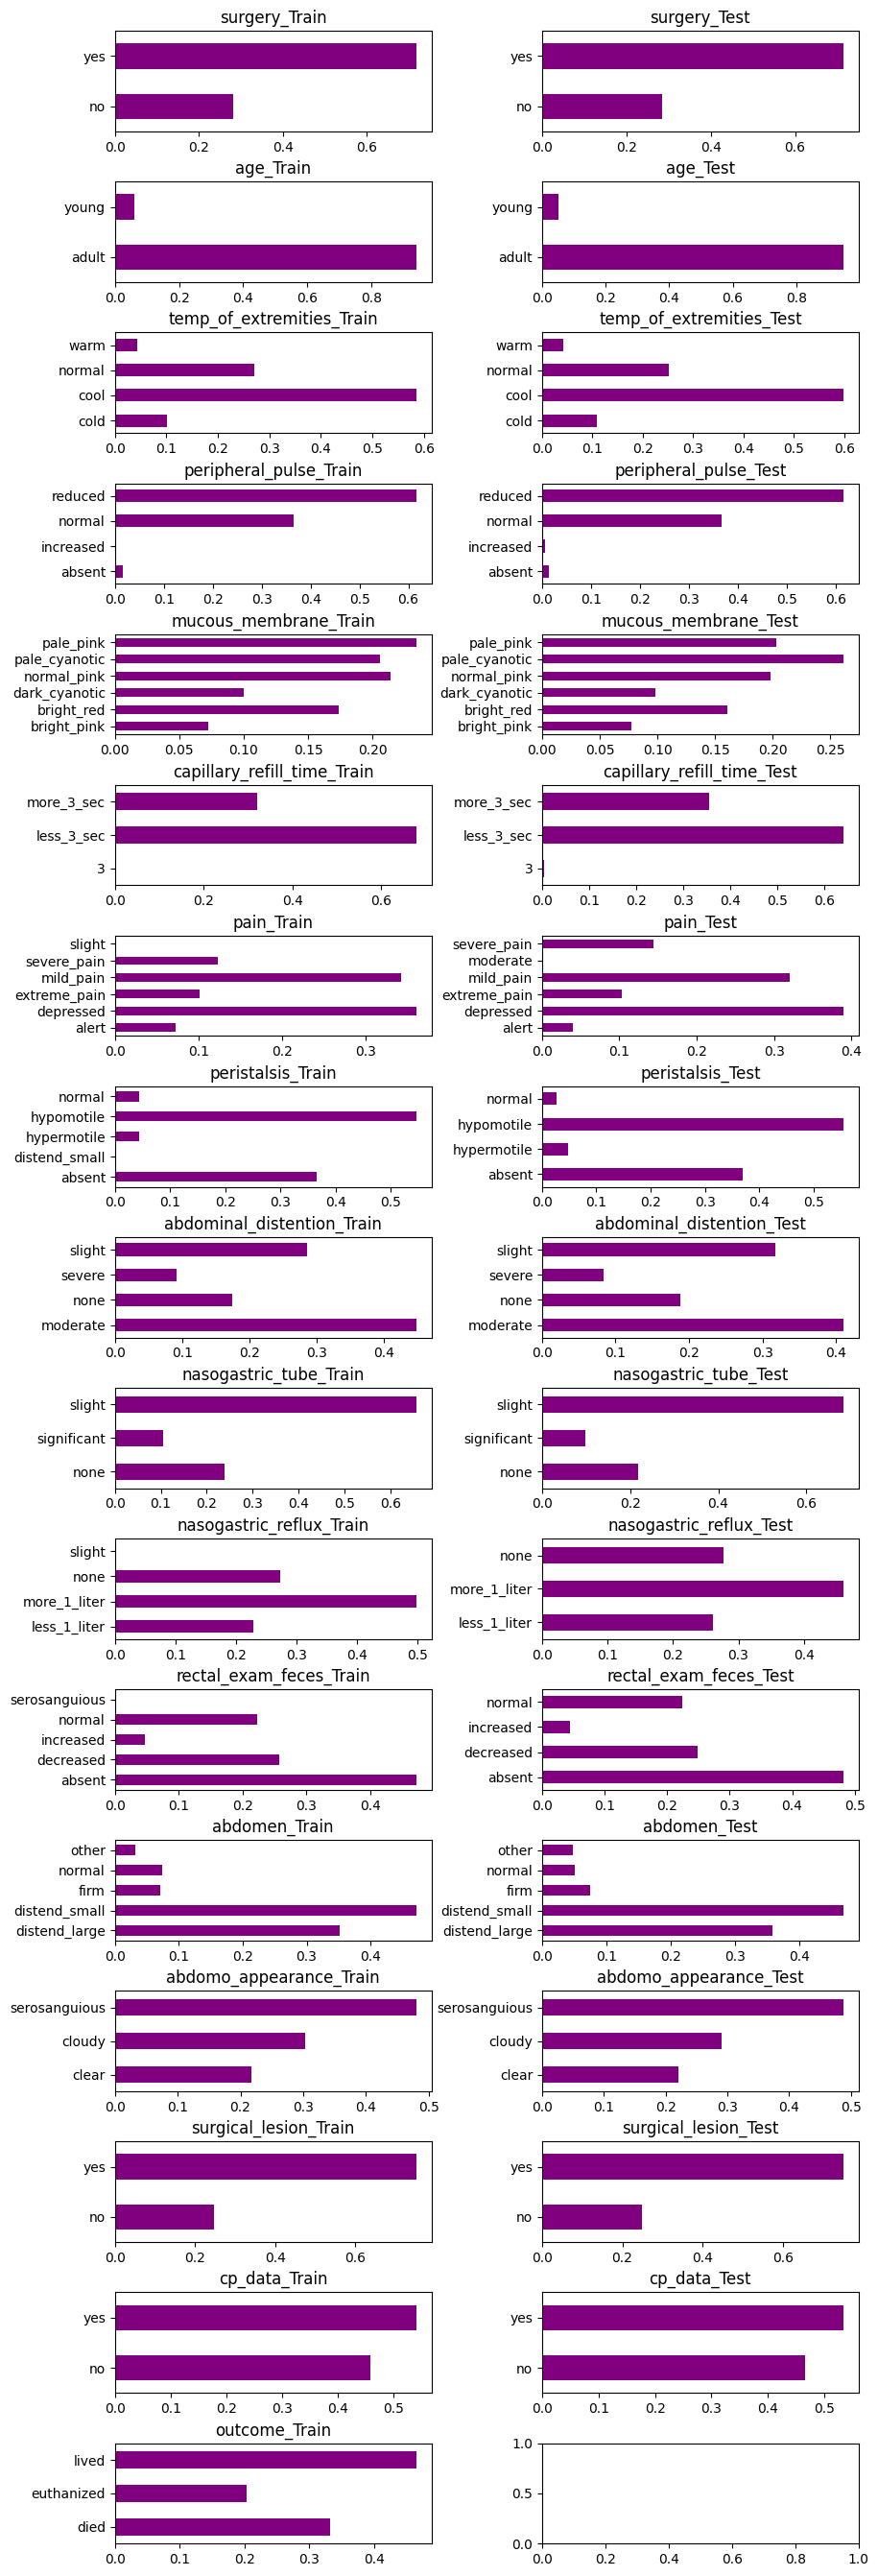

In [61]:
#单变量分布1
fig, axes = plt.subplots(len(cat_cols), 2, figsize = (10, len(cat_cols)* 2), 
                             gridspec_kw = {'wspace': 0.35, 'hspace': 0.5})
for i, column in enumerate(cat_cols):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    a = train_df[column].value_counts(normalize = True)
    a.sort_index().plot.barh(ax = ax1, color = 'purple')
    ax1.set_title(f"{column}_Train")
    ax1.set(ylabel = '')
    if column=='outcome':
        continue
    b = test_df[column].value_counts(normalize = True)
    b.sort_index().plot.barh(ax = ax2, color = 'purple')
    ax2.set_title(f"{column}_Test")
    ax2.set(ylabel = '')

## 1.pain  训练集slight  测试集moderate
##   考虑两者合并之后编码
## 2.peristalsis 训练集多一个distend_small（1个样本）
## 3.nasogastric_reflux 训练集多一个slight（1个样本）
## 4.rectal_exam_feces 训练集多一个serosanguious（1个样本）
##   234不删除可能也不影响，删除好像也不影响
## 5.mucous 中的pale_cyanotic分布不太一样（异常突出）
## 6.abdominal_distention、nasogastric_tube、nasogastric_reflux中的none   
##   考虑将None和none 都做none（普通字符串none的意义）处理？
##  （用isnull统计的None被视为无值，但是none被视为普通字符串）
##   此处处理完之后还需要做一下训练集和测试集分布分析


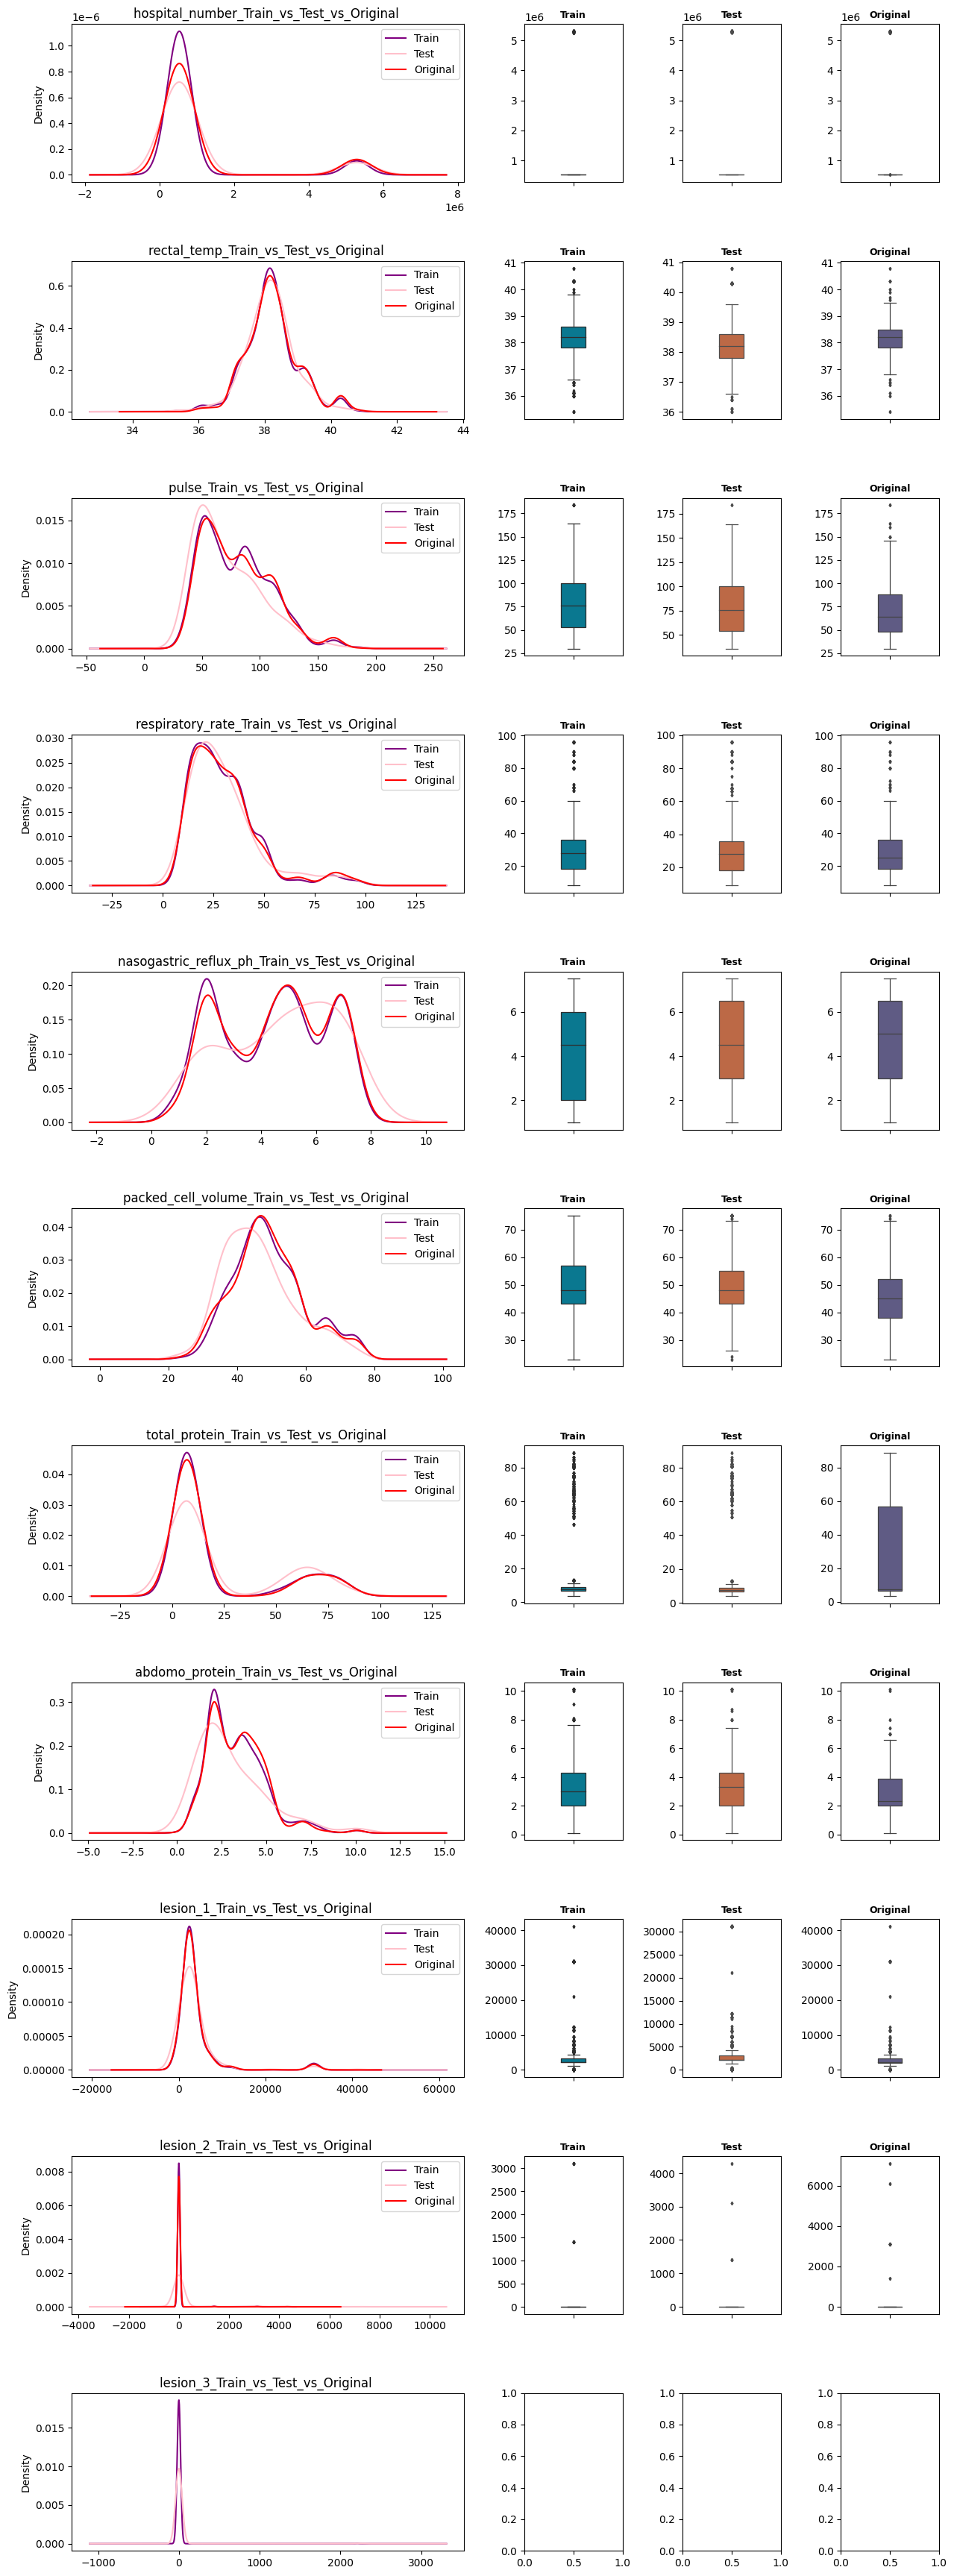

In [62]:
# 单变量分布
fig, axes = plt.subplots(len(num_cols), 4, figsize = (15, len(num_cols)* 4), 
                             gridspec_kw = {'wspace': 0.35, 'hspace': 0.5, 'width_ratios': [0.80, 0.20, 0.20, 0.20]})
for i, column in enumerate(num_cols):
    ax = axes[i,0]
    a = train_df[column]
    a.plot(ax = ax,kind='density', color = 'purple',label='Train')
    ax.set_title(f"{column}_Train_vs_Test_vs_Original ")
    ax.set(ylabel = '')
    c = original_df[column]
    c.plot(ax = ax,kind='density', color = 'pink',label='Original')
    if column=='lesion_3':
        continue
    b = test_df[column]
    b.plot(ax = ax,kind='density', color = 'red',label='Test')
    ax.legend(['Train','Test','Original'])
    ax = axes[i,1]
    sns.boxplot(y = a, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');
    ax = axes[i,2];
    sns.boxplot(y = b, width = 0.25, fliersize= 2.25,saturation = 0.6, linewidth = 0.90, color = '#E4591E',ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');
    ax = axes[i,3];
    sns.boxplot(y = c, width = 0.25, fliersize= 2.25,saturation = 0.6, linewidth = 0.90, color = '#544E91',ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Original",fontsize = 9, fontweight= 'bold');
# 多变量分析

## 1.单变量分析，训练集和测试集分布基本一致，除了hospital_number和lesion_3差别
## 2.hospital_number
## 3.lesion_3

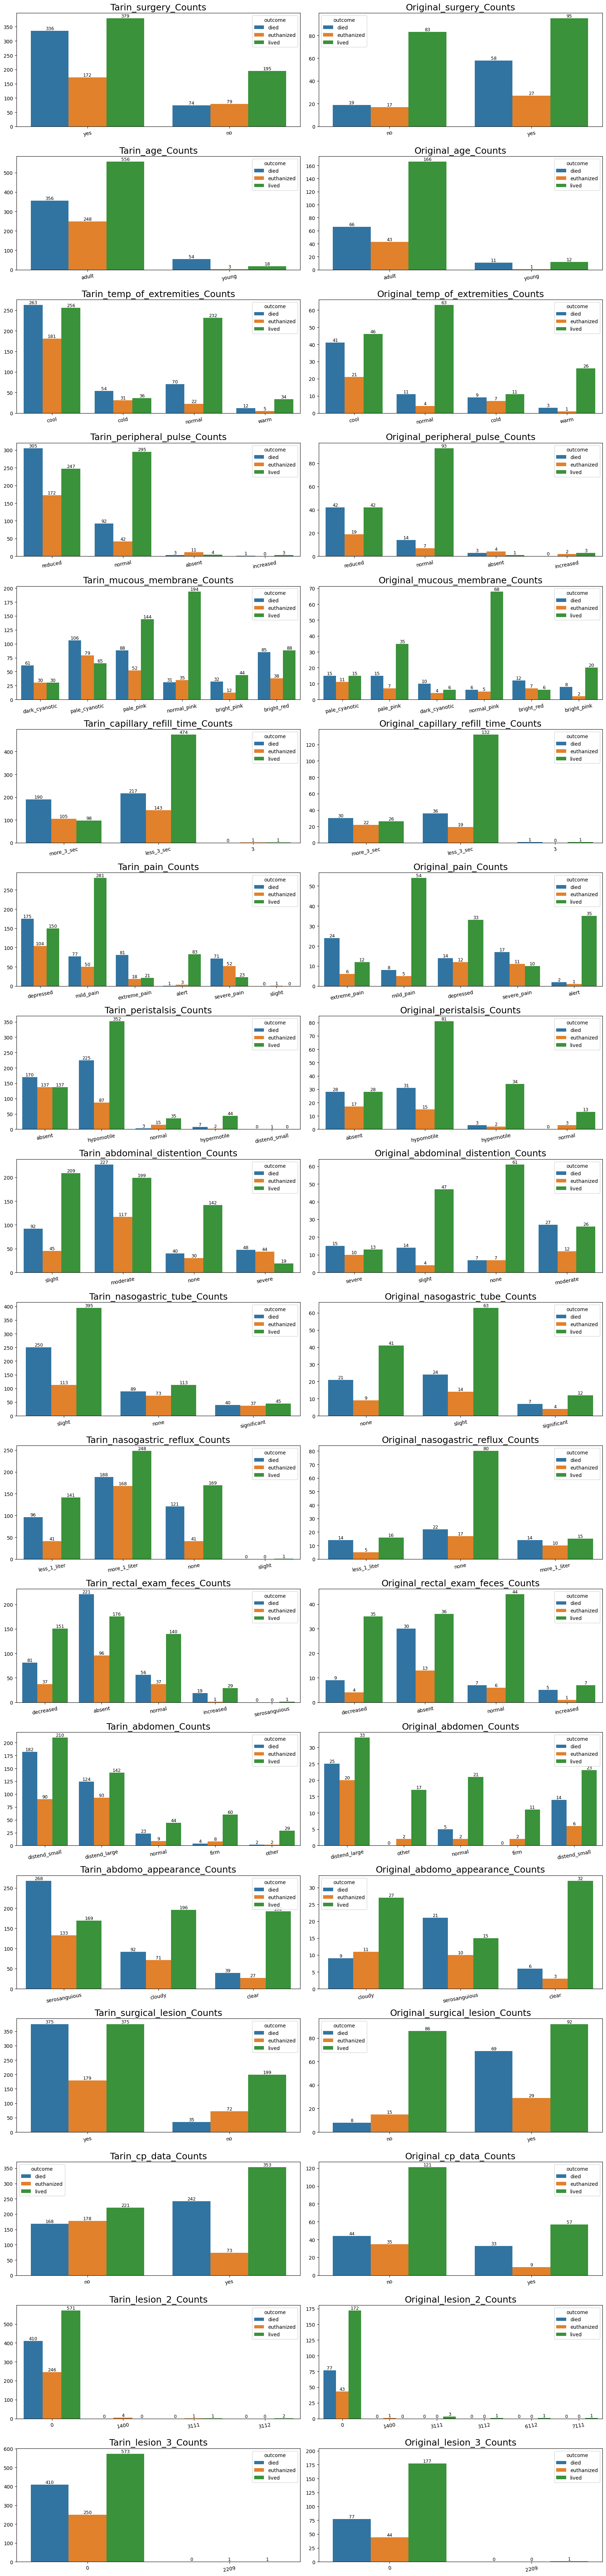

In [82]:
# 联合outcome的单变量分布
def plot_count(train_df,original_df,columns,hue,other_features=['lesion_1','lesion_2','lesion_3','hospital_number']):
    columns = columns + other_features
    n_rows = len(columns)
    fig, axes = plt.subplots(n_rows, 2, figsize=(17, 4 * n_rows))
    for i, column in enumerate(columns):
        ax = axes[i,0]
        sns.countplot(data=train_df, x=column, ax=ax,hue=hue)
        ax.set_title(f'Tarin_{column}_Counts', fontsize=18)
        ax.set_xlabel(None, fontsize=16)
        ax.set_ylabel(None, fontsize=16)
        ax.tick_params(axis='x', rotation=10)
        for p in ax.patches:
            value = int(p.get_height())
            ax.annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)
            
        ax = axes[i,1]
        sns.countplot(data=original_df, x=column, ax=ax,hue=hue)
        ax.set_title(f'Original_{column}_Counts', fontsize=18)
        ax.set_xlabel(None, fontsize=16)
        ax.set_ylabel(None, fontsize=16)
        ax.tick_params(axis='x', rotation=10)
        for p in ax.patches:
            value = int(p.get_height())
            ax.annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)

    ylim_top = ax.get_ylim()[1]
    ax.set_ylim(top=ylim_top * 1.1)
    for i in range(len(columns), len(axes)):
        axes[i,0].axis('off')
        axes[i,1].axis('off')

    # fig.suptitle(plotname, fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
plot_count(train_df,original_df,[cat_col for cat_col in cat_cols if cat_col != target],'outcome',other_features=['lesion_2','lesion_3'])

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


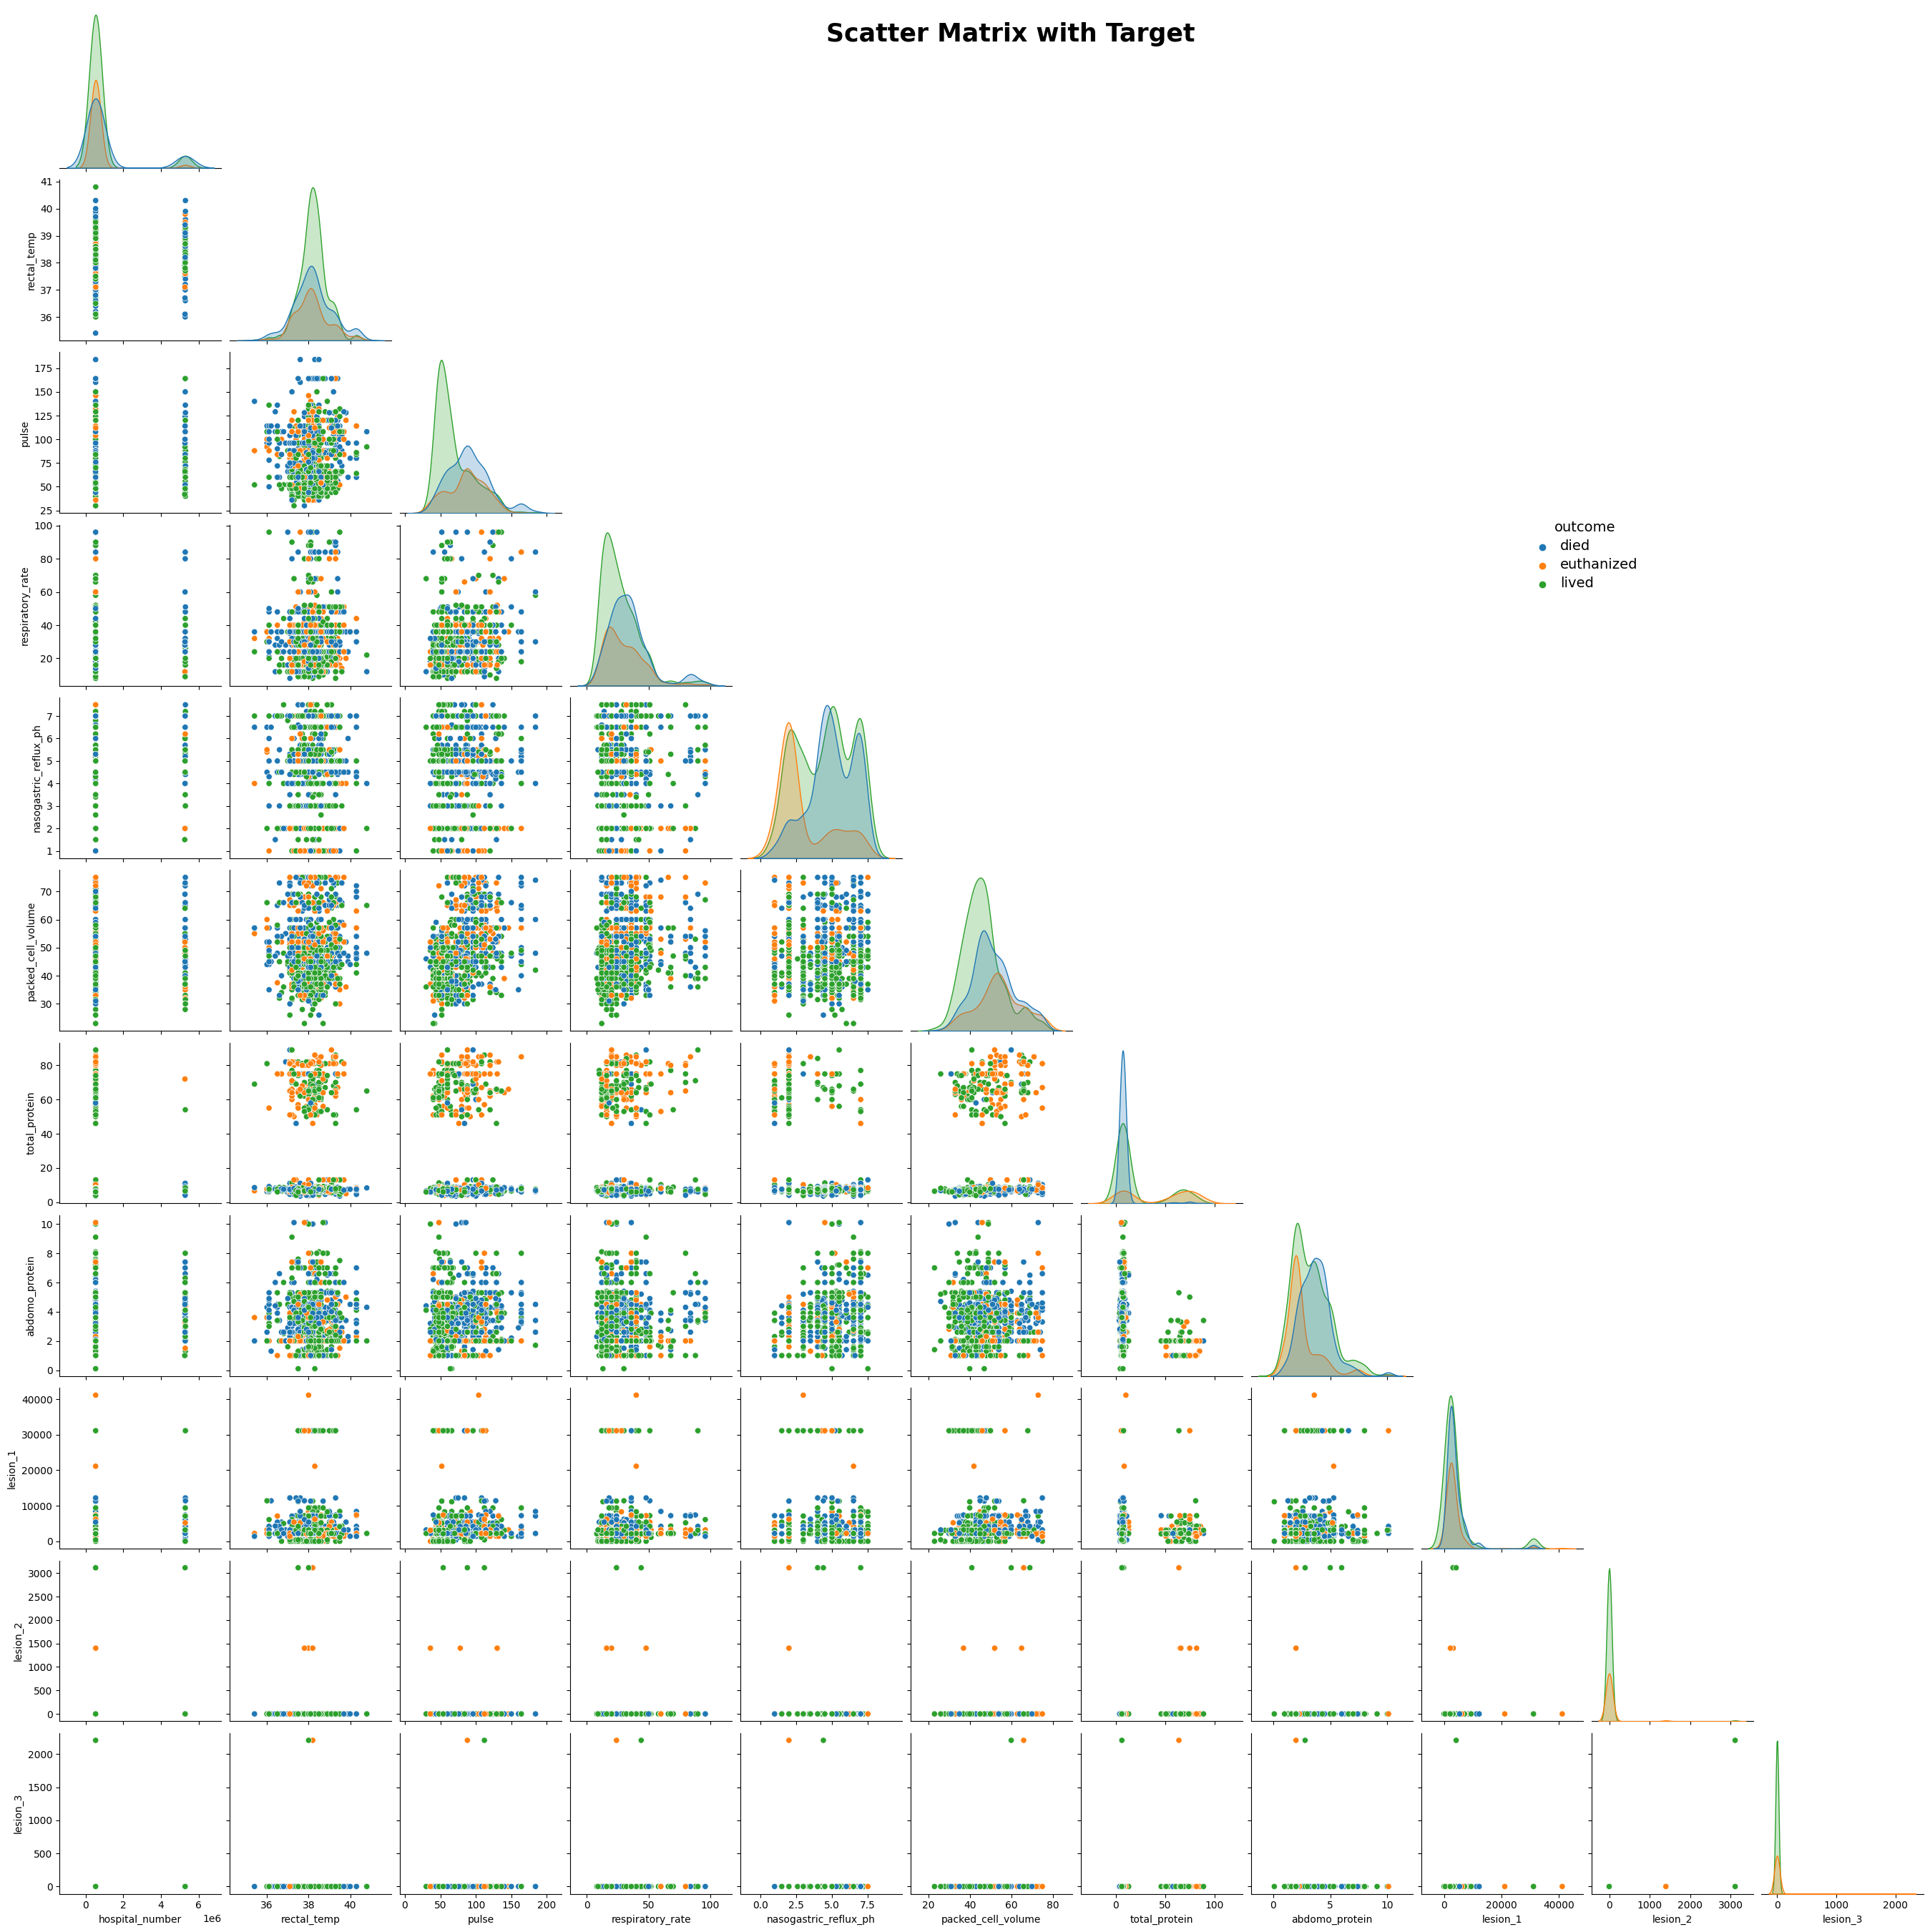

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

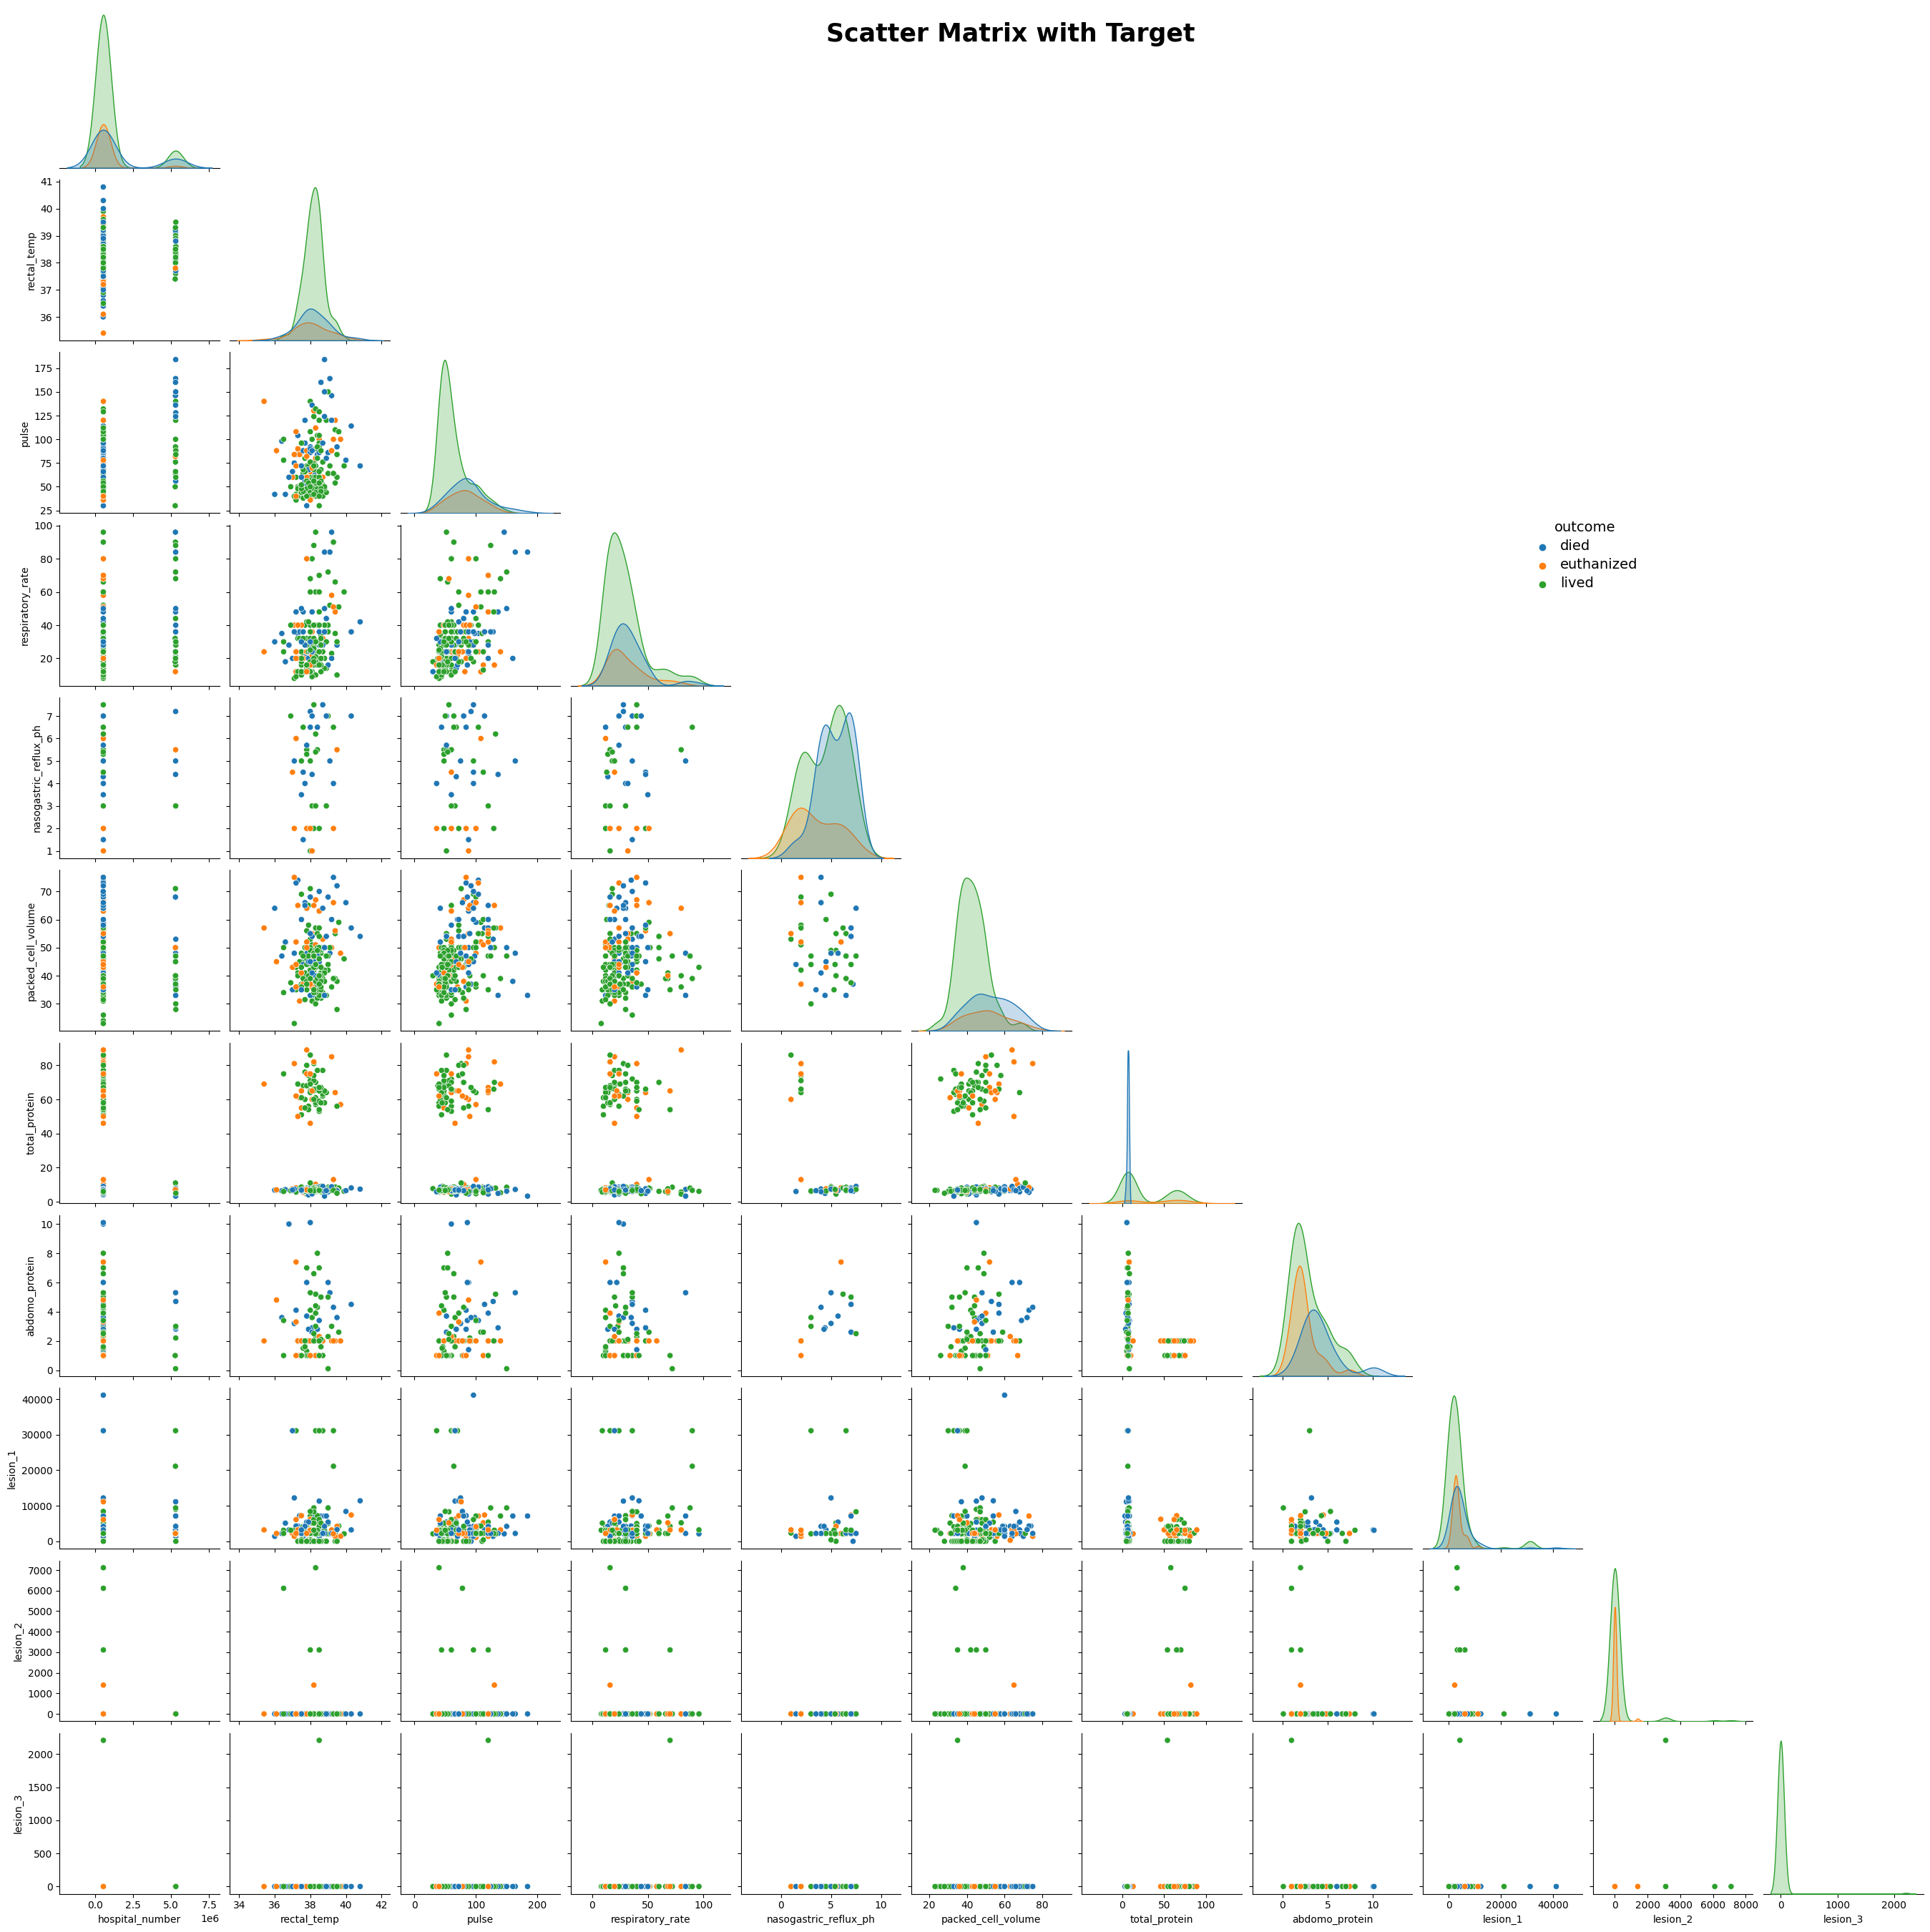

<Figure size 640x480 with 0 Axes>

In [83]:
# 双变量配对分析
def plot_pair(train_df,num_var,target,plotname):
    g = sns.pairplot(data=train_df, x_vars=num_var, y_vars=num_var, hue=target, corner=True)
    g._legend.set_bbox_to_anchor((0.8, 0.7))
    g._legend.set_title(target)
    g._legend.loc = 'upper center'
    g._legend.get_title().set_fontsize(14)
    for item in g._legend.get_texts():
        item.set_fontsize(14)

    plt.suptitle(plotname, ha='center', fontweight='bold', fontsize=25, y=0.98)
    plt.show()

plot_pair(train_df,num_cols,target,plotname = 'Scatter Matrix with Target')
plt.tight_layout()
plot_pair(original_df,num_cols,target,plotname = 'Scatter Matrix with Target')
plt.tight_layout()

Text(0.5, 1.0, 'pearson_corr_of_test')

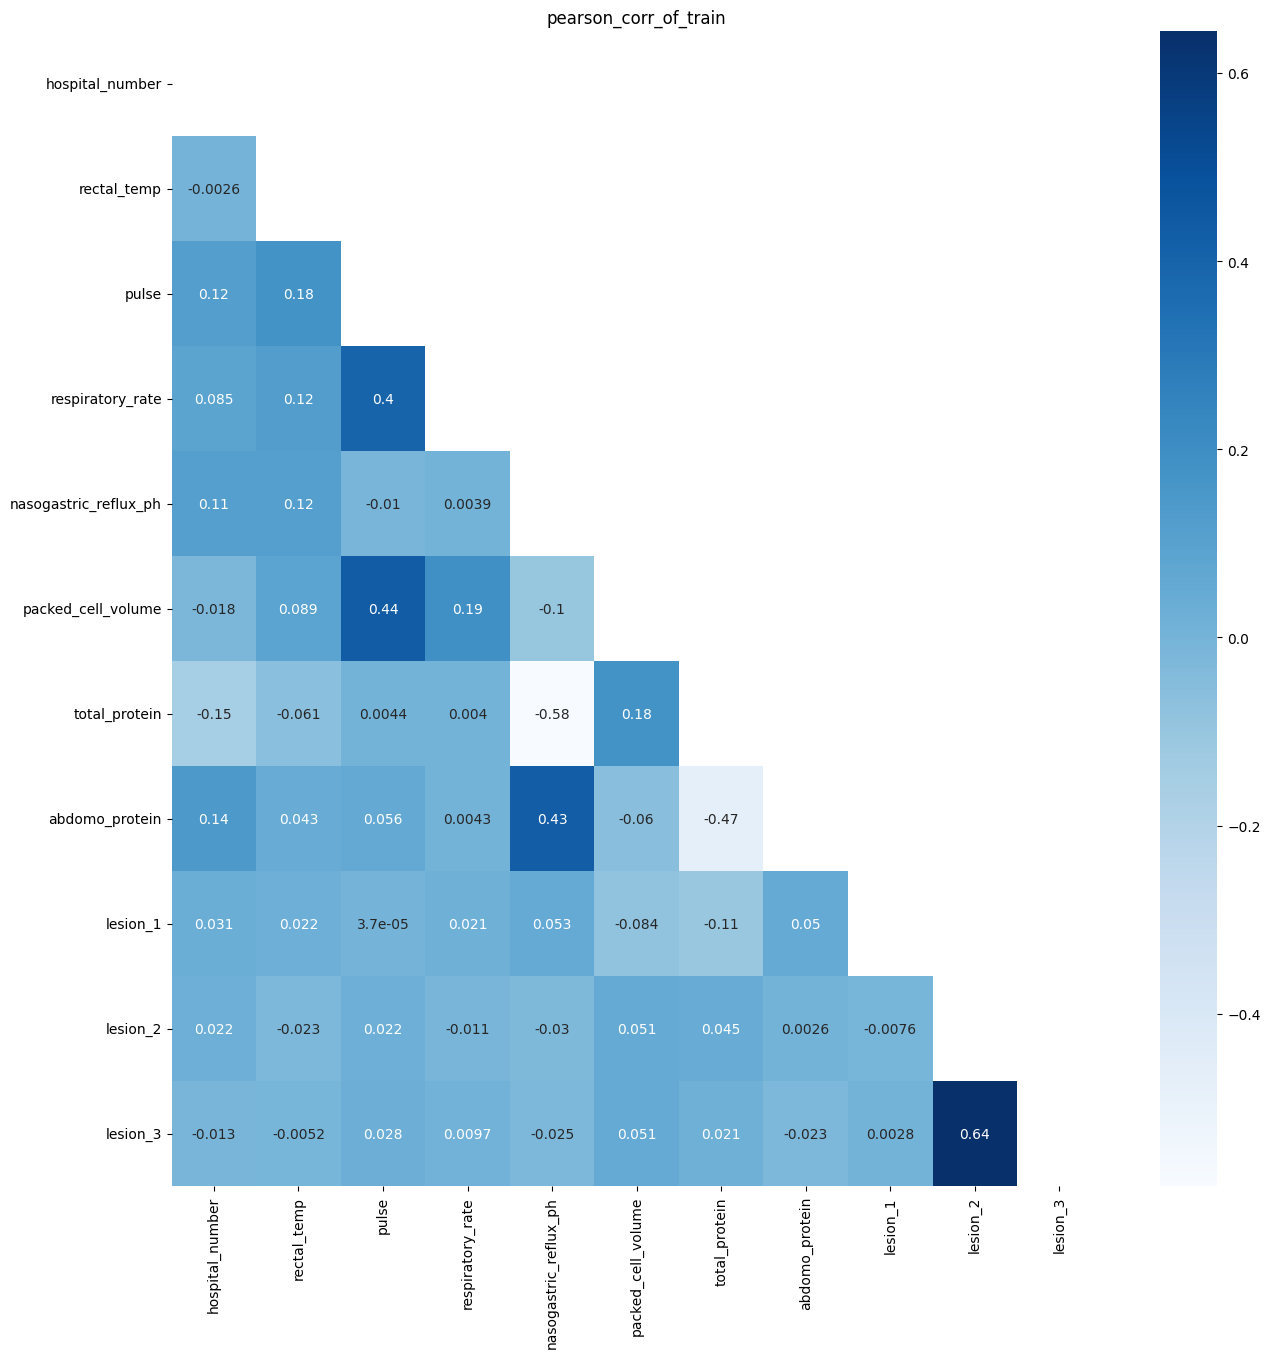

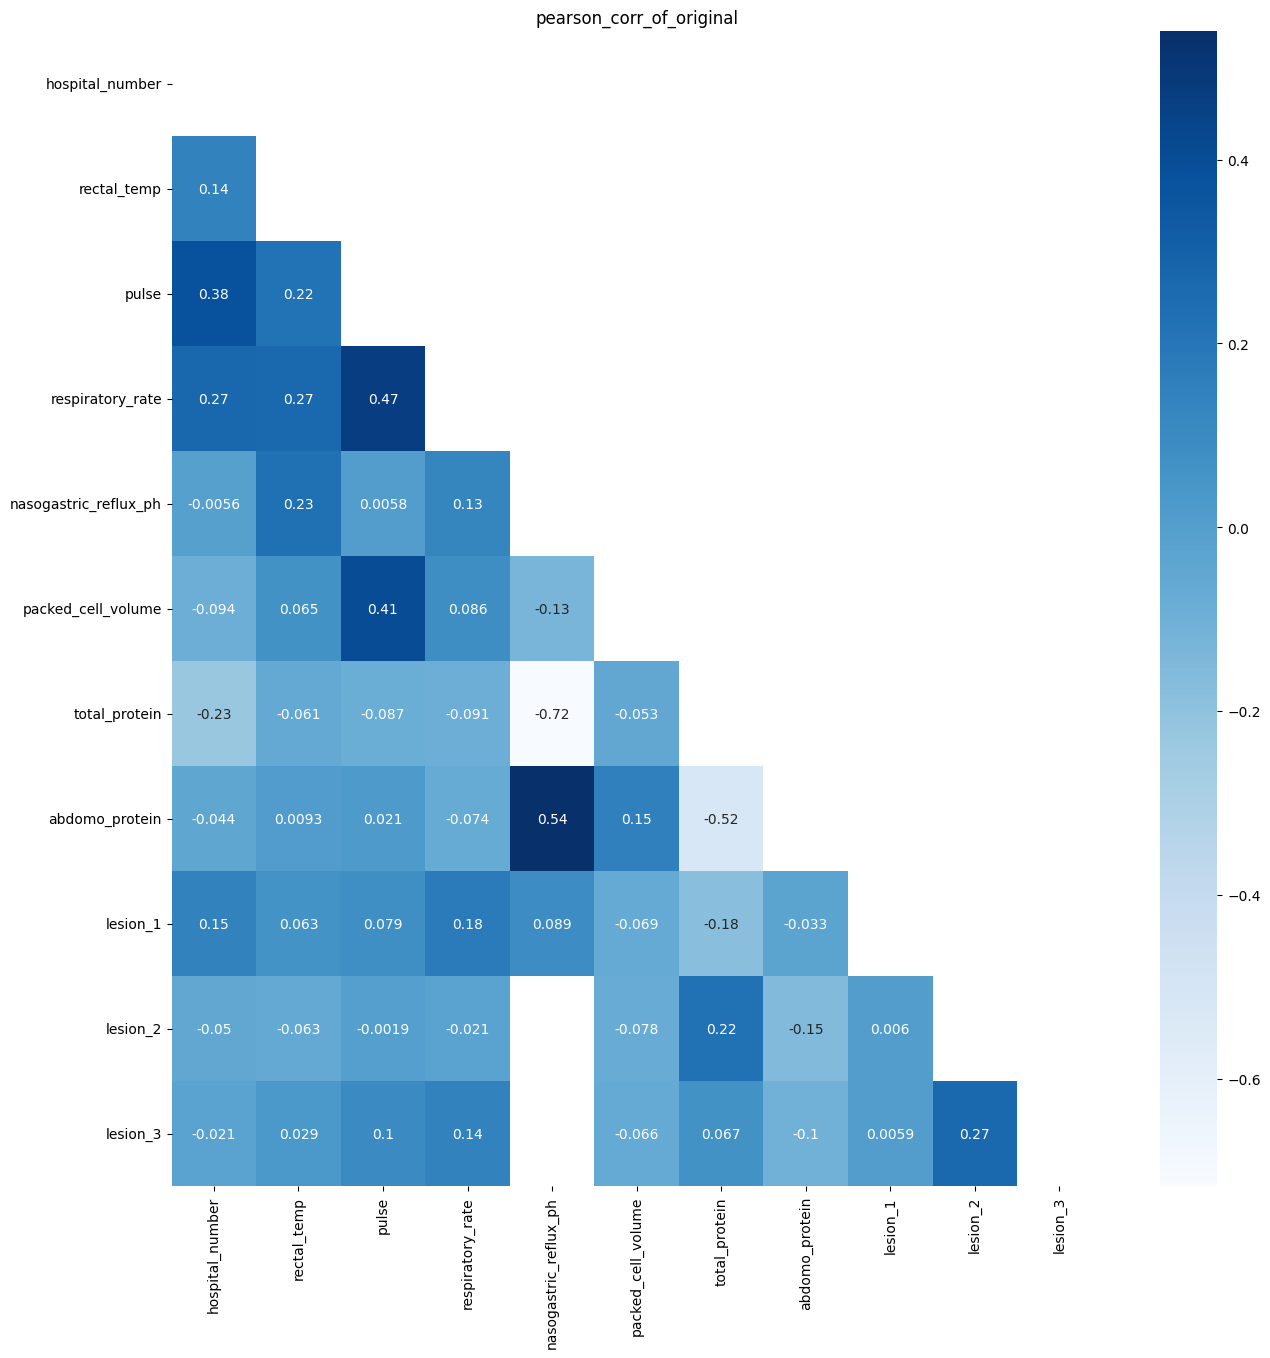

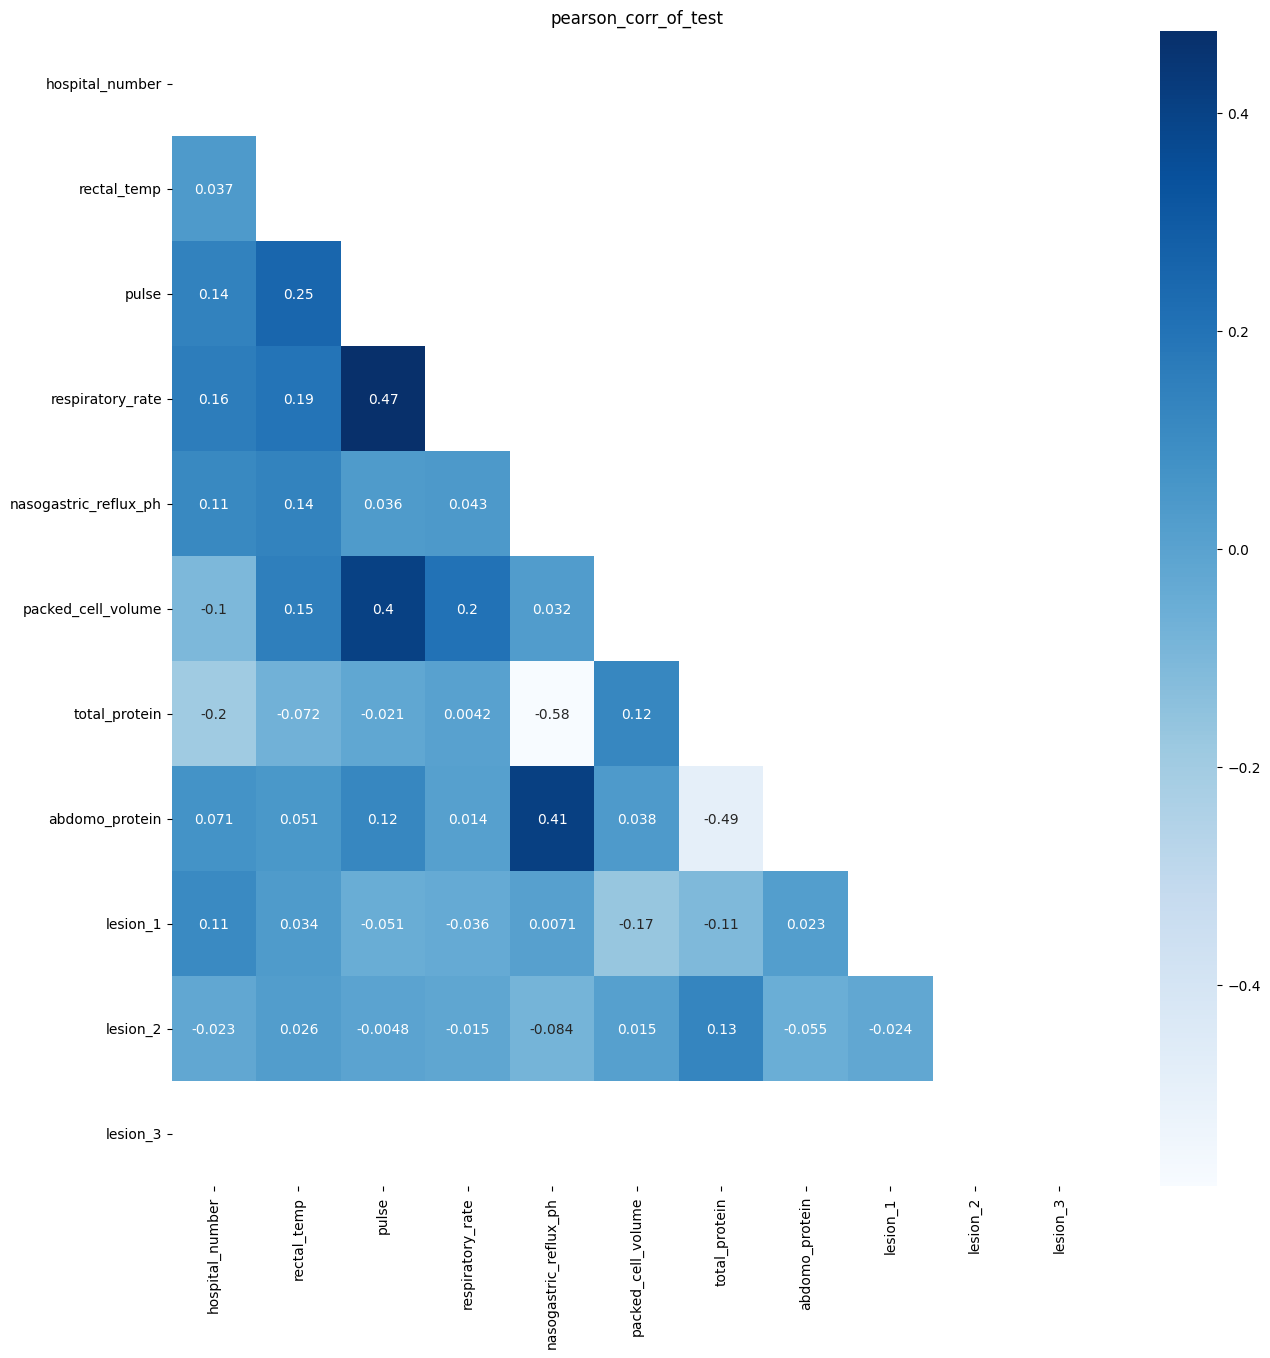

In [87]:
method = "pearson"
plt.figure(figsize=(15,15))
corr = train_df[num_cols].corr(method = "pearson")# 皮尔逊相关
mask = np.triu(np.triu(corr))
sns.heatmap(data = corr,annot=True, cmap = 'Blues', mask=mask)
plt.title(method+"_corr_of_train")

plt.figure(figsize=(15,15))
corr = original_df[num_cols].corr(method = "pearson")# 皮尔逊相关
mask = np.triu(np.triu(corr))
sns.heatmap(data = corr,annot=True, cmap = 'Blues', mask=mask)
plt.title(method+"_corr_of_original")

plt.figure(figsize=(15,15))
corr = test_df[num_cols].corr(method = "pearson")# 皮尔逊相关
mask = np.triu(np.triu(corr))
sns.heatmap(data = corr,annot=True, cmap = 'Blues', mask=mask)
plt.title(method+"_corr_of_test")

## 1.pulse 和 respiratory_rate、packed_cell_volume正相关比较明显
## 2.nasogastric_reflux_ph 和total_protein、abdomo_protein分别呈负相关、正相关
## 3.total_protein和abdomo_protein呈正相关
## 4.lesion_2和lesion_3呈正相关

## 卡方检验

In [67]:
def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m') 
    else:
        print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')  

for i in cat_cols:
    chi_squared_test(train_df, i, target)

surgery has a significant relationship with the target variable.
age has a significant relationship with the target variable.
temp_of_extremities has a significant relationship with the target variable.
peripheral_pulse has a significant relationship with the target variable.
mucous_membrane has a significant relationship with the target variable.
capillary_refill_time has a significant relationship with the target variable.
pain has a significant relationship with the target variable.
peristalsis has a significant relationship with the target variable.
abdominal_distention has a significant relationship with the target variable.
nasogastric_tube has a significant relationship with the target variable.
nasogastric_reflux has a significant relationship with the target variable.
rectal_exam_feces has a significant relationship with the target variable.
abdomen has a significant relationship with the target variable.
abdomo_appearance has a significant relationship with the target variabl

## **特征工程**

In [68]:
## 1.通用组合特征
## 2.业务统计特征
## 我们需要融合？
## NLP特征池衍生（from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer）

## **pipeline**

In [69]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value="NaN")),
    ('encoder', OrdinalEncoder())
])
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols),
])
train_prepared = full_pipeline.fit_transform(train_df)
display(train_df)
display(pd.DataFrame(train_prepared))

# 或者单独处理？
# train_df[target] = train_df[target].map({'died':0,'euthanized':1,'lived':2})
# class Xformer(TransformerMixin, BaseEstimator):
#     """
#     This class is used to create secondary features from the existing data.
#     We correct the hospital number in the test set to equal the nearest training data number too
#     """;
    
#     def __init__(self, hnb_only_test:list, hnb_only_train: list): 
#         self.sec_ftre_req = CFG.sec_ftre_req;
#         self.hnb_only_test = hnb_only_test;
#         self.hnb_only_train = hnb_only_train;
    
#     def fit(self, X, y= None, **params):
#         "This method adjusts the only-test hospital number to the nearest training set number";
        
#         hnb_diff = \
#         {nb: abs(nb - base_val) for nb in X['hospital_number'].unique() for base_val in self.hnb_only_test};
#         self.hnb_mapper = {self.hnb_only_test[0]: min(hnb_diff, key= hnb_diff.get)}
    
#         self.ip_cols = X.columns;
#         return self;
    
#     def transform(self, X, y= None, **params):       
#         global strt_ftre;
#         df    = X.copy();  
        
#         # Correcting the test-only hospital number with the nearest training set number:-
#         try:
#             df['hospital_number'] = df['hospital_number'].astype(np.int64).map(self.hnb_mapper).astype(np.int64);
#         except:
#             PrintColor(f"---> Check the hospital number assignment", Fore.RED);
#             df.loc[df['hospital_number'] == 528338, "hospital_number"] = 528355;
        
#         # Splitting the lesion 1 feature into its components:-
#         l1_prf = \
#         df['lesion_1'].astype(np.int64).\
#         astype(str).str.split('', expand = True).\
#         applymap(lambda x: 0 if x in ['', None, np.NaN] else x).astype(np.int8).\
#         add_prefix("lesion_1_").\
#         drop(columns = ['lesion_1_0', "lesion_1_6"], errors = "ignore");
        
#         df = pd.concat([df, l1_prf], axis=1);
#         del l1_prf;

#         if self.sec_ftre_req == "Y":
#             df['rectal_temp_risk'] = np.where(df.rectal_temp >= 37.8,1,0).astype(np.int8);
#             df['pulse_risk']       = np.where(df.pulse >= 40,1,0).astype(np.int8);
#             df['cell_vol_risk']    = np.where(df.packed_cell_volume >= 50, 1,0).astype(np.int8);
#             df['protein_risk']     = np.where(df.total_protein >= 7.5, 1,0).astype(np.int8);
                
#         if CFG.sec_ftre_req != "Y": 
#             PrintColor(f"Secondary features are not required", color = Fore.RED);    
        
#         self.op_cols = df.columns;  
#         return df;
    
#     def get_feature_names_in(self, X, y=None, **params): 
#         return self.ip_cols;    
    
#     def get_feature_names_out(self, X, y=None, **params): 
#         return self.op_cols;
# Encoding the categorical columns with domain based encoding:-
# 参考格式
# class Encoder(TransformerMixin, BaseEstimator):
#     """
#     This class is used to create encoded features from the existing object data
#     """; 
    
#     def __init__(self): pass;
    
#     def fit(self, X, y= None, **params):
#         self.ip_cols = X.columns;
#         return self;
    
#     def transform(self, X, y= None, **params):
#         """
#         This method performs manual label encoding for the category columns and lesion columns.
#         This is done as per the original data instructions- refer the original metadata page for details
#         """;
        
#         df = X.copy();
#         df['surgery'] = df['surgery'].map({'no': 1, 'yes': 0}).astype(np.int8);
#         df['age']     = df['age'].map({'adult': 0, 'young': 1}).astype(np.int8);
#         df['temp_of_extremities'] = \
#         df['temp_of_extremities'].map({'None': 0, "normal":1, "warm": 2, "cool":3, "cold":4}).astype(np.int8);
#         df['peripheral_pulse'] = \
#         df['peripheral_pulse'].map({'NA': 0, "None": 0, 
#                                       "normal":1, "increased": 2, "reduced":3, "absent":4}
#                                   ).astype(np.int8);
#         df['mucous_membrane'] = \
#         df['mucous_membrane'].map({'NA': 0, "None": 0, "normal":1, "normal_pink":1, "pink": 2, "bright" : 3,
#                                      "bright_pink":3, "pale_pink":4 , "pale_cyanotic": 5, 
#                                      "bright_red":6, "injected": 6, "dark_cyanotic": 7
#                                     }
#                                  ).astype(np.int8);
#         df['capillary_refill_time'] = \
#         df['capillary_refill_time'].map({'NA': 0, "None": 0, "less_3_sec":1, "3": 2, "more_3_sec": 2}).astype(np.int8); 
#         df['pain'] = \
#         df['pain'].map({"NA": 0, "None": 0, "alert" : 1, "no_pain": 2, "depressed": 3, 
#                         "mild_pain": 4, 'slight': 3, "moderate": 4, "severe_pain": 5, "extreme_pain": 6
#                        }
#                       ).astype(np.int8);
#         df['peristalsis'] = \
#         df['peristalsis'].map({"NA": 0, "None": 0, "hypermotile": 1, 'distend_small':1, 
#                                "normal": 2,"hypomotile": 3, "absent": 4}
#                              ).astype(np.int8);
#         df['abdominal_distention'] = \
#         df['abdominal_distention'].map({"NA": 0, "none": 1, "slight": 2, "moderate": 3, "severe": 4}).astype(np.int8);
#         df['nasogastric_tube'] = \
#         df['nasogastric_tube'].map({"NA": 0, "none": 1, "slight": 2, "significant": 3}).astype(np.int8);
#         df['nasogastric_reflux'] = \
#         df['nasogastric_reflux'].map({"NA": 0, "none": 1, 'slight':2, "less_1_liter": 2, "more_1_liter": 3}).astype(np.int8);
#         df['rectal_exam_feces'] = \
#         df['rectal_exam_feces'].map({"NA": 0, "None": 0, 
#                                      "normal": 1, "increased": 3, "decreased": 4, "absent": 5, 'serosanguious':6}
#                                    ).astype(np.int8);
#         df['abdomen'] = \
#         df['abdomen'].map({"NA": 0, "None":0, 
#                            "normal": 1, "other": 2, "firm": 3, "distend_small": 4, "distend_large": 5}
#                          ).astype(np.int8);
#         df['abdomo_appearance'] = \
#         df['abdomo_appearance'].map({"NA": 0, "None":0,"clear": 1, "cloudy": 2, "serosanguious": 3}).astype(np.int8);
#         df['surgical_lesion'] = df['surgical_lesion'].map({"no": 1, "yes": 0}).astype(np.int8);
#         df['cp_data'] = df['cp_data'].map({"no": 1, "yes": 0}).astype(np.int8);
        
#         #  Encoding the lesion 2 as 0/ non-zero:-
#         df['lesion_2'] = df['lesion_2'].clip(0, 1).astype(np.int8);
        
#         df[['hospital_number', 'lesion_1', 'pain']] = \
#         df[['hospital_number', 'lesion_1', 'pain']].astype(int);
                  
#         self.op_cols = df.columns; 
#         return df;
    
#     def get_feature_names_in(self, X, y=None, **params): 
#         return self.ip_cols;    
    
#     def get_feature_names_out(self, X, y=None, **params): 
#         return self.op_cols;  
# Scaling:-
# class Scaler(TransformerMixin, BaseEstimator):
#     """
#     This class aims to create scaling for the provided dataset
#     """;
    
#     def __init__(self, scl_method: str, scale_req: str, scl_cols):
#         self.scl_method = scl_method;
#         self.scale_req  = scale_req;
#         self.scl_cols   = scl_cols;
        
#     def fit(self,X, y=None, **params):
#         "This function calculates the train-set parameters for scaling";
        
#         self.params          = X[self.scl_cols].describe(percentiles = [0.25, 0.50, 0.75]).drop(['count'], axis=0).T;
#         self.params['iqr']   = self.params['75%'] - self.params['25%'];
#         self.params['range'] = self.params['max'] - self.params['min'];
        
#         return self;
    
#     def transform(self,X, y=None, **params):  
#         "This function transform the relevant scaling columns";
        
#         df = X.copy();
#         if self.scale_req == "Y":
#             if CFG.scl_method == "Z":
#                 df[self.scl_cols] = (df[self.scl_cols].values - self.params['mean'].values) / self.params['std'].values;
#             elif CFG.scl_method == "Robust":
#                 df[self.scl_cols] = (df[self.scl_cols].values - self.params['50%'].values) / self.params['iqr'].values;
#             elif CFG.scl_method == "MinMax":
#                 df[self.scl_cols] = (df[self.scl_cols].values - self.params['min'].values) / self.params['range'].values;
#         else:
#             PrintColor(f"Scaling is not needed", color = Fore.RED);
    
#         return df;

surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
id                                                                           
0        yes  adult           530001         38.1  132.0              24.0   
1        yes  adult           533836         37.5   88.0              12.0   
2        yes  adult           529812         38.3  120.0              28.0   
3        yes  adult          5262541         37.1   72.0              30.0   
4         no  adult          5299629         38.0   52.0              48.0   
...      ...    ...              ...          ...    ...               ...   
1230     yes  adult           535246         38.5  129.0              48.0   
1231     yes  adult           528570         37.5   60.0              50.0   
1232     yes  young           529685         37.5   84.0              40.0   
1233     yes  adult           534784         38.1   70.0              16.0   
1234     yes  adult           528548         38.1   54.0              36.0   

     temp_of_extremities peripheral_pulse mucous_membrane  \
id                                                          
0                   cool          reduced   dark_cyanotic   
1                   cool           normal   pale_cyanotic   
2                   cool          reduced       pale_pink   
3                   cold          reduced       pale_pink   
4                 normal           normal     normal_pink   
...                  ...              ...             ...   
1230                cool          reduced       pale_pink   
1231                cool          reduced   pale_cyanotic   
1232              normal          reduced     normal_pink   
1233              normal          reduced      bright_red   
1234              normal           normal       pale_pink   

     capillary_refill_time  ... packed_cell_volume total_protein  \
id                          ...                                    
0               more_3_sec  ...               57.0           8.5   
1               more_3_sec  ...               33.0          64.0   
2               less_3_sec  ...               37.0           6.4   
3               more_3_sec  ...               53.0           7.0   
4               less_3_sec  ...               47.0           7.3   
...                    ...  ...                ...           ...   
1230            more_3_sec  ...               57.0          66.0   
1231            less_3_sec  ...               35.0           6.4   
1232            less_3_sec  ...               40.0           5.9   
1233            less_3_sec  ...               58.0          74.0   
1234            less_3_sec  ...               45.0           6.0   

     abdomo_appearance abdomo_protein surgical_lesion  lesion_1 lesion_2  \
id                                                                         
0        serosanguious            3.4             yes      2209        0   
1        serosanguious            2.0             yes      2208        0   
2        serosanguious            3.4             yes      5124        0   
3               cloudy            3.9             yes      2208        0   
4               cloudy            2.6              no         0        0   
...                ...            ...             ...       ...      ...   
1230     serosanguious            2.0             yes      2206        0   
1231     serosanguious            3.6             yes      2209        0   
1232            cloudy            7.0             yes       400        0   
1233            cloudy            2.0             yes      2209        0   
1234             clear            3.6             yes      2124        0   

     lesion_3  cp_data     outcome  
id                                  
0           0       no        died  
1           0       no  euthanized  
2           0       no       lived  
3           0      yes       lived  
4           0      yes       lived  
...       ...      ...         ...  
1230        0       no    

0         1         2         3         4         5         6   \
0    -0.313086 -0.129621  1.801773 -0.368142  1.093380  0.702421 -0.483319   
1    -0.310258 -0.890705  0.289582 -1.097830 -1.230314 -1.576449  1.598010   
2    -0.313226  0.124074  1.389357 -0.124913 -0.455749 -1.196638 -0.562072   
3     3.177363 -1.398095 -0.260306 -0.003299 -1.230314  0.322609 -0.539571   
4     3.204717 -0.256468 -0.947666  1.091232  1.351568 -0.247108 -0.528321   
...        ...       ...       ...       ...       ...       ...       ...   
1230 -0.309218  0.377769  1.698669  1.091232 -1.230314  0.702421  1.673013   
1231 -0.314142 -0.890705 -0.672722  1.212846 -0.713937 -1.386544 -0.562072   
1232 -0.313319 -0.890705  0.152110  0.604774 -0.713937 -0.911779 -0.580823   
1233 -0.309559 -0.129621 -0.329042 -0.854601 -1.230314  0.797374  1.973025   
1234 -0.314158 -0.129621 -0.878930  0.361545 -0.713937 -0.437014 -0.577073   

            7         8         9   ...   18   19   20   21   22   23   24  \
0     0.068659 -0.298737 -0.075465  ...  1.0  4.0  3.0  1.0  2.0  2.0  3.0   
1    -0.812647 -0.298921 -0.075465  ...  1.0  1.0  1.0  2.0  1.0  2.0  3.0   
2     0.068659  0.237648 -0.075465  ...  4.0  1.0  3.0  3.0  0.0  1.0  3.0   
3     0.383411 -0.298921 -0.075465  ...  4.0  1.0  3.0  2.0  2.0  2.0  2.0   
4    -0.434944 -0.705212 -0.075465  ...  4.0  2.0  3.0  1.0  4.0  4.0  2.0   
...        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
1230 -0.812647 -0.299289 -0.075465  ...  1.0  1.0  1.0  2.0  0.0  1.0  3.0   
1231  0.194560 -0.298737 -0.075465  ...  4.0  4.0  3.0  3.0  2.0  2.0  3.0   
1232  2.334874 -0.631608 -0.075465  ...  4.0  4.0  3.0  3.0  3.0  3.0  2.0   
1233 -0.812647 -0.298737 -0.075465  ...  4.0  4.0  1.0  2.0  1.0  2.0  2.0   
1234  0.194560 -0.314378 -0.075465  ...  1.0  2.0  3.0  3.0  0.0  2.0  1.0   

       25   26   27  
0     1.0  0.0  0.0  
1     1.0  0.0  1.0  
2     1.0  0.0  2.0  
3     1.0  1.0  2.0  
4     0.0  1.0  2.0  
...   ...  ...  ...  
1230  1.0  0.0  2.0  
1231  1.0  1.0  0.0  
1232  1.0  1.0  2.0  
1233  1.0  0.0  2.0  
1234  1.0  1.0  2.0  

[1235 rows x 28 columns]

In [ ]:
onehot_cols = none
class Encoder(TransformerMixin, BaseEstimator):
    def __init__(self): pass;
    
    def fit(self, X, y= None, **params):
        self.ip_cols = X.columns;
        return self;
    
    def transform(self, X, y= None, **params):
        df = X.copy();
        df['surgery'] = df['surgery'].map({'no': 1, 'yes': 0}).astype(np.int8);
        df['age']     = df['age'].map({'adult': 0, 'young': 1}).astype(np.int8);
        df['temp_of_extremities'] = \
        df['temp_of_extremities'].map({'None': 0, "normal":1, "warm": 2, "cool":3, "cold":4}).astype(np.int8);
        df['peripheral_pulse'] = \
        df['peripheral_pulse'].map({'NA': 0, "None": 0, 
                                      "normal":1, "increased": 2, "reduced":3, "absent":4}
                                  ).astype(np.int8);
        df['mucous_membrane'] = \
        df['mucous_membrane'].map({'NA': 0, "None": 0, "normal":1, "normal_pink":1, "pink": 2, "bright" : 3,
                                     "bright_pink":3, "pale_pink":4 , "pale_cyanotic": 5, 
                                     "bright_red":6, "injected": 6, "dark_cyanotic": 7
                                    }
                                 ).astype(np.int8);
        df['capillary_refill_time'] = \
        df['capillary_refill_time'].map({'NA': 0, "None": 0, "less_3_sec":1, "3": 2, "more_3_sec": 2}).astype(np.int8); 
        df['pain'] = \
        df['pain'].map({"NA": 0, "None": 0, "alert" : 1, "no_pain": 2, "depressed": 3, 
                        "mild_pain": 4, 'slight': 3, "moderate": 4, "severe_pain": 5, "extreme_pain": 6
                       }
                      ).astype(np.int8);
        df['peristalsis'] = \
        df['peristalsis'].map({"NA": 0, "None": 0, "hypermotile": 1, 'distend_small':1, 
                               "normal": 2,"hypomotile": 3, "absent": 4}
                             ).astype(np.int8);
        df['abdominal_distention'] = \
        df['abdominal_distention'].map({"NA": 0, "none": 1, "slight": 2, "moderate": 3, "severe": 4}).astype(np.int8);
        df['nasogastric_tube'] = \
        df['nasogastric_tube'].map({"NA": 0, "none": 1, "slight": 2, "significant": 3}).astype(np.int8);
        df['nasogastric_reflux'] = \
        df['nasogastric_reflux'].map({"NA": 0, "none": 1, 'slight':2, "less_1_liter": 2, "more_1_liter": 3}).astype(np.int8);
        df['rectal_exam_feces'] = \
        df['rectal_exam_feces'].map({"NA": 0, "None": 0, 
                                     "normal": 1, "increased": 3, "decreased": 4, "absent": 5, 'serosanguious':6}
                                   ).astype(np.int8);
        df['abdomen'] = \
        df['abdomen'].map({"NA": 0, "None":0, 
                           "normal": 1, "other": 2, "firm": 3, "distend_small": 4, "distend_large": 5}
                         ).astype(np.int8);
        df['abdomo_appearance'] = \
        df['abdomo_appearance'].map({"NA": 0, "None":0,"clear": 1, "cloudy": 2, "serosanguious": 3}).astype(np.int8);
        df['surgical_lesion'] = df['surgical_lesion'].map({"no": 1, "yes": 0}).astype(np.int8);
        df['cp_data'] = df['cp_data'].map({"no": 1, "yes": 0}).astype(np.int8);
        
        #  Encoding the lesion 2 as 0/ non-zero:-
        df['lesion_2'] = df['lesion_2'].clip(0, 1).astype(np.int8);
        
        df[['hospital_number', 'lesion_1', 'pain']] = \
        df[['hospital_number', 'lesion_1', 'pain']].astype(int);
                  
        self.op_cols = df.columns; 
        return df;
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;

## Pipline后分析

num__hospital_number          0.202552
num__pulse                    0.154980
num__nasogastric_reflux_ph    0.137037
cat__abdominal_distention     0.081495
cat__capillary_refill_time    0.062101
cat__abdomen                  0.045354
cat__nasogastric_tube         0.029744
cat__peristalsis              0.023672
cat__age                      0.000000
Name: MI Scores, dtype: float64

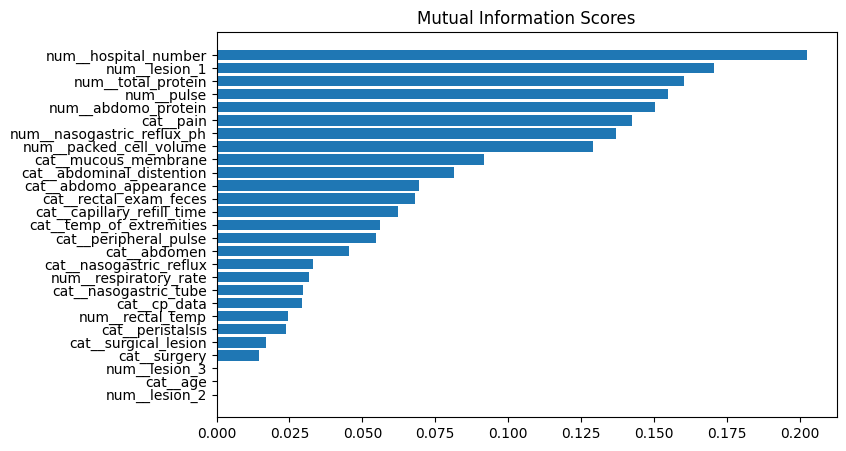

In [70]:
## 信息增益，互信息
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    columns = full_pipeline.get_feature_names_out()
    columns = np.delete(columns, len(columns) - 1)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = train_prepared[:, :-1].copy()
y = train_prepared[:, -1]

mi_scores = make_mi_scores(X, y)
display(mi_scores[::3]) # show a few features with their MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Text(0.5, 1.0, 'Distribution of hospital_number, by outcome')

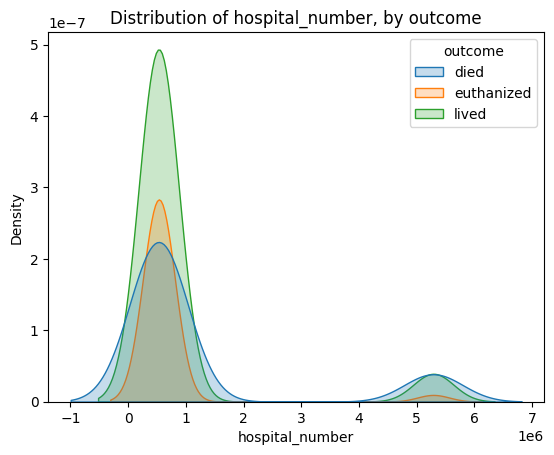

In [71]:
sns.kdeplot(data=train_df, x='hospital_number', hue='outcome', fill=True)
plt.title("Distribution of hospital_number, by outcome")

## PCA分析

In [72]:
train_X = train_prepared[:, :-1]
train_y = train_prepared[:, -1]
pca = PCA(n_components = 10)
X2D = pca.fit_transform(train_X)
display(pd.DataFrame(X2D))
display(pd.DataFrame(pca.explained_variance_ratio_))

0         1         2         3         4         5         6  \
0     0.913072  1.349450 -1.967495  1.600566  1.123379 -1.148619 -0.104324   
1     2.420723 -1.491486  1.671472  0.077930 -0.444137  0.137240  0.114221   
2     0.912153 -1.738953 -0.620703 -2.003240 -1.029390  0.532316  1.159624   
3    -0.081070 -2.049668 -0.511335 -1.816328 -0.134324  0.181113  0.311318   
4    -2.957268  0.240607 -1.817194  1.300177 -0.826114  1.460350 -0.100888   
...        ...       ...       ...       ...       ...       ...       ...   
1230  4.644646 -0.525125 -0.329331 -0.169048 -1.117857  0.810423 -0.067866   
1231 -1.283369 -1.668437  0.107624 -0.097106  0.877849 -1.264899  0.449893   
1232 -2.512101 -0.752112 -0.761726  0.423379  1.210421 -1.261127  0.487544   
1233 -0.221209  1.203978  2.952795  0.809167  0.562771 -1.319162  0.804761   
1234  1.408884 -2.478070  0.060486  0.380875  0.289513 -0.601008  0.905174   

             7         8         9  
0     0.255602 -0.766000 -0.551413  
1     1.291032 -0.224083  1.089928  
2    -0.880426  0.755198 -0.757926  
3     0.077992  0.013333  2.933782  
4     0.200197 -0.437363  2.310687  
...        ...       ...       ...  
1230 -1.180320 -0.453008  0.266455  
1231 -0.955011 -0.397496  0.060409  
1232 -0.446366 -0.940227  0.634660  
1233 -1.681636 -0.734081  0.746513  
1234  1.291949  0.787659 -0.771590  

[1235 rows x 10 columns]

0
0  0.144249
1  0.110074
2  0.079153
3  0.074889
4  0.060510
5  0.059230
6  0.048815
7  0.044196
8  0.041447
9  0.037547

## 网格搜索相关

In [73]:
# # Pipeline specifics:-
# from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler;
# from sklearn.impute import SimpleImputer as SI;
# from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
#                                      StratifiedKFold as SKF,
#                                      KFold, 
#                                      RepeatedKFold as RKF, 
#                                      cross_val_score);
# from sklearn.inspection import permutation_importance;
# from sklearn.feature_selection import mutual_info_classif, RFE;
# from sklearn.pipeline import Pipeline, make_pipeline;
# from sklearn.base import BaseEstimator, TransformerMixin;
# from sklearn.compose import ColumnTransformer;

# # ML Model training:-
# from sklearn.metrics import f1_score, confusion_matrix, make_scorer;
# from xgboost import DMatrix, XGBClassifier;
# from lightgbm import LGBMClassifier, log_evaluation, early_stopping;
# from catboost import CatBoostClassifier, Pool;
# from sklearn.ensemble import (RandomForestClassifier as RFC, 
#                               ExtraTreesClassifier as ETC,
#                               AdaBoostClassifier as ABC,
#                               BaggingClassifier as BC,
#                               HistGradientBoostingClassifier as HGBC
#                              );
# from sklearn.linear_model import LogisticRegression as LC;
# Mdl_Master = \
# {'CBC': CatBoostClassifier(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
#                               'objective'           : "MultiClass",
#                               'eval_metric'         : "Accuracy",
#                               'classes_count'       : 3,
#                               'bagging_temperature' : 0.10,
#                               'colsample_bylevel'   : 0.75,
#                               'iterations'          : 1000,
#                               'learning_rate'       : 0.075,
#                               'od_wait'             : 3,
#                               'max_depth'           : 4,
#                               'l2_leaf_reg'         : 0.85,
#                               'min_data_in_leaf'    : 6,
#                               'random_strength'     : 0.65, 
#                               'max_bin'             : 80,
#                               'verbose'             : 0,
#                               'use_best_model'      : True,
#                            }
#                          ), 

#   'LGBMC': LGBMClassifier(**{'device'            : "gpu" if CFG.gpu_switch == "ON" else "cpu",
#                              'objective'         : 'multiclass',
#                              'metric'            : 'none',
#                              'boosting_type'     : 'gbdt',
#                              'random_state'      : CFG.state,
#                              'colsample_bytree'  : 0.5,
#                              'subsample'         : 0.65,
#                              'learning_rate'     : 0.08,
#                              'max_depth'         : 4,
#                              'n_estimators'      : 1000,
#                              'num_leaves'        : 72,                    
#                              'reg_alpha'         : 0.01,
#                              'reg_lambda'        : 1.75,
#                              'verbose'           : -1,
#                          }
#                       ),

#   'XGBC': XGBClassifier(**{'tree_method'        : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
#                            'objective'          : 'multi:softprob',
#                            'random_state'       : CFG.state,
#                            'colsample_bytree'   : 0.7,
#                            'learning_rate'      : 0.07,
#                            'max_depth'          : 4,
#                            'n_estimators'       : 1100,                         
#                            'reg_alpha'          : 0.025,
#                            'reg_lambda'         : 1.75,
#                            'min_child_weight'   : 5,
#                            'early_stopping_rounds' : CFG.nbrnd_erly_stp,
#                         }
#                        ),
 
#    'RFC' : RFC(n_estimators     = 150, 
#                criterion        = 'gini',
#                max_depth        = 4,
#                min_samples_leaf = 5,
#                max_features     = 'log2',
#                bootstrap        = True,
#                oob_score        = True,
#                random_state     = CFG.state,
#                verbose          =0,
#               ), 
 
#   "HGBC" : HGBC(loss              = 'categorical_crossentropy',
#                 learning_rate     = 0.075,
#                 early_stopping    = True,
#                 max_iter          = 200,
#                 max_depth         = 4,
#                 min_samples_leaf  = 5,
#                 l2_regularization = 1.75,
#                 scoring           = myscorer,
#                 random_state      = CFG.state,
#                )
# };

## 单模型----> 随机森林、LightGBM、XGBoost、CatBoost

## 均值融合、加权融合、Stacking融合(分类问题用逻辑回归、否则用贝叶斯回归(bayesianRidge))

## trick